In [12]:
%matplotlib notebook
import numpy as np
import pickle
with open('images_dict.pkl', 'rb') as handle:
        images_dict = pickle.load(handle)
with open('keys_array.pkl', 'rb') as handle:
        keys_array = pickle.load(handle)
with open('truth_tags.pkl', 'rb') as handle:
        truth_tags = pickle.load(handle)
# with open('keys_array.pkl', 'rb') as handle:
#         keys_array = pickle.load(handle)
# with open('keys_array.pkl', 'rb') as handle:
#         keys_array = pickle.load(handle)
# with open('keys_array.pkl', 'rb') as handle
#         keys_array = pickle.load(handle)

In [13]:
from mynn.layers.dense import dense
from mynn.initializers.normal import normal
import mygrad as mg


class TagTrainer:
    def __init__(self):
        """ Initializes all of the encoder and decoder layers in our model, setting them
        as attributes of the model.
        
        Parameters
        ----------
        context_words : int
            The number of context words included in our vocabulary
            
        d : int
            The dimensionality of our word embeddings
        """
        self.dense1 = dense(512, 150, weight_initializer = normal)
        
    
    
    def __call__(self, x):
        ''' Passes data as input to our model, performing a "forward-pass".
        
        This allows us to conveniently initialize a model `m` and then send data through it
        to be classified by calling `m(x)`.
        
        '''
        return self.dense1(x)
    
    
    @property
    def parameters(self):
        return self.dense1.parameters

In [14]:
from noggin import create_plot
from mynn.optimizers.adam import Adam
model = TagTrainer()

In [26]:
optim = Adam(model.parameters)
idxs = np.arange(keys_array.shape[0])
np.random.shuffle(idxs)
train = keys_array[idxs[:80000]]
train_data = np.zeros((80000,512))
for i in range(len(train)):
    train_data[i] = images_dict[train[i]]
y = np.linalg.norm(train_data, axis = 1).reshape(-1,1)
train_data/=y

<IPython.core.display.Javascript object>


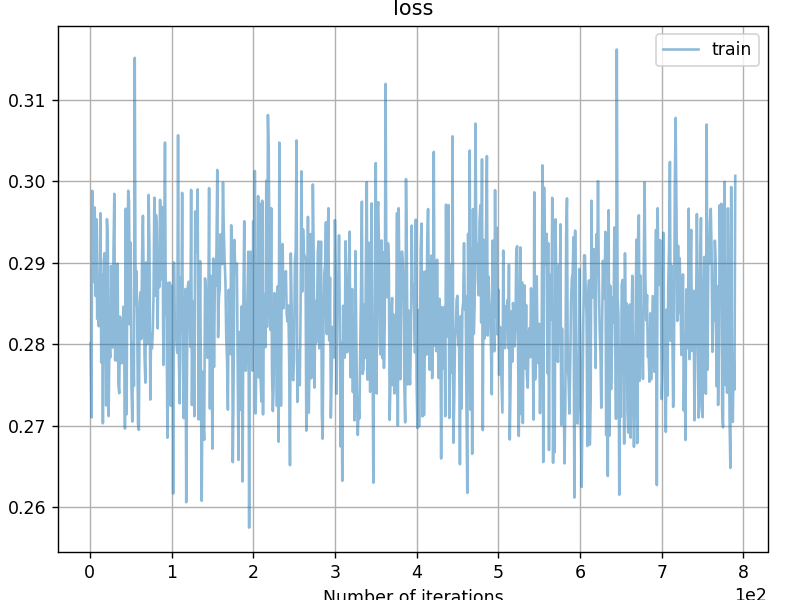

In [27]:

plotter, fig, ax = create_plot(metrics="loss")


In [19]:
def cos_compare(pred, perms_array):
    x = np.sum(pred*perms_array, axis = 1)
    return np.argmax(x)
def cos_loss(pred, truth_batch):
    x = mg.einsum("ij,ij", pred, truth_batch) / len(pred)
    return 1-x

In [28]:
batch_size = 100

# for epoch_cnt in range(50):
idxs = np.arange(train.shape[0])
np.random.shuffle(idxs)  

for batch_cnt in range(0, train.shape[0] // batch_size):
    batch_indices = idxs[(batch_cnt * batch_size):((batch_cnt + 1) * batch_size)]
    id_batch = train[batch_indices]
    data_batch = train_data[batch_indices]

    pred = model(data_batch)
    pred /= mg.sqrt(mg.sum(pred**2, axis = 1 )).reshape(-1,1)
    truth_batch = np.zeros((batch_size,150))
    for i in range(len(id_batch)):
        truth_batch[i] = truth_tags[id_batch[i]][cos_compare(pred[i].data,truth_tags[id_batch[i]])]
    loss = cos_loss(pred, truth_batch)
    loss.backward()
    optim.step()
    loss.null_gradients()

    plotter.set_train_batch({"loss" : loss.item()}, batch_size)
plotter.set_train_epoch()

In [8]:
import matplotlib.pyplot as plt
from urllib.request import urlopen
from gensim.models.keyedvectors import KeyedVectors as KV
with open("url_dict.pkl", "rb") as read_file:
    url_dict = pickle.load(read_file)
glove = KV.load_word2vec_format('./glove.6B.50d.txt.w2v', binary=False)

C:\Users\jaimo\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\jaimo\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [31]:
model.parameters[0].shape

(512, 150)

In [29]:
np.save('model', model.parameters)

In [194]:
with open('captions_dict.pkl', 'rb') as handle:
        captions_dict = pickle.load(handle)

In [234]:
def test(id):
    gloves = model(images_dict[id]).data.reshape(-1)
    tags = list()
    for i in range(3):
        x = glove.similar_by_vector(gloves[i*50:(i+1)*50])
        n = 0
        new_tag = x[0][0]
        while new_tag in tags:
            n+=1
            new_tag = x[n][0]
        tags.append(new_tag)
#     fig, ax = plt.subplots()
#     data = urlopen(url_dict[id])
#     img = plt.imread(data, format='jpg')
#     ax.imshow(img)
    return '#'+' #'.join(tags)

In [250]:
list1 = list()
list2 = list()
for i in range(100):
    list1.append(truth_test(keys_array[i]))
    list2.append(test(keys_array[i]))

In [4]:
tags = ['aba','bub', 'cab']
print('#'+' #'.join(tags))

#aba #bub #cab


In [9]:
def truth_test(id):
    tags = list()
    for i in range(3):
        x = truth_tags[id][0,i*50:(i+1)*50]
        x = glove.similar_by_vector(x)
        tags.append(x[0][0])
    return tags

In [10]:
import pickle
with open('truth_tags.pkl', 'rb') as handle:
        truth_tags = pickle.load(handle)

In [11]:
truth_test(57870)

['chairs', 'table', 'long']